In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import time
import pandas as pd
import torch
random.seed(0)
np.random.seed(0)

In [2]:
torch.cuda.empty_cache()

In [3]:
!lscpu |grep 'Model name'

Model name:          Intel(R) Xeon(R) CPU @ 2.30GHz


In [4]:
!nvidia-smi

Wed Dec 15 20:47:07 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   51C    P8    30W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# genetic alg with numpy

## parametrs numpy

In [26]:
num_weight = 5 
weight = np.random.uniform(low=-1.0, high=1.0, size=num_weight) 
individum = 5000
pop_size = (individum, num_weight)
new_pop = np.random.uniform(low=-1.0, high=1.0, size=pop_size)
max_gen = 1
num_parents = 2

In [27]:
print('true weight', weight)
print('new pop\n', new_pop)

true weight [0.66507301 0.03364956 0.85383909 0.9436131  0.3502597 ]
new pop
 [[-0.37579978  0.15136754 -0.25742706 -0.46199194 -0.09164045]
 [-0.17244575  0.22117854  0.7072353  -0.30073256 -0.10217601]
 [ 0.66626616 -0.61820565 -0.74905874  0.08800952  0.66222845]
 ...
 [-0.69068839 -0.89988935 -0.71075812 -0.98184224  0.07858217]
 [-0.58662962 -0.96565905 -0.77828165 -0.6787283  -0.34378878]
 [ 0.52249562 -0.58819168 -0.34989498  0.53163957  0.49869455]]


## visual

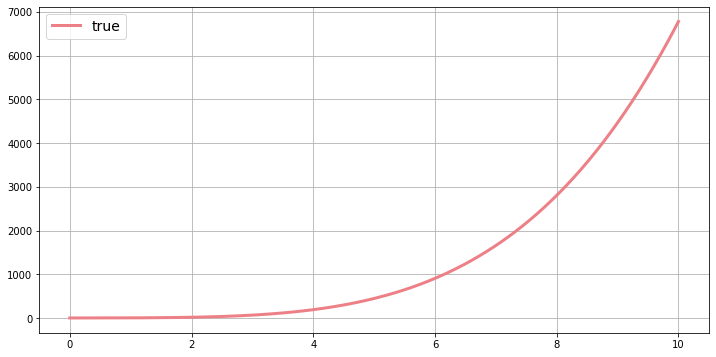

In [28]:
x = np.linspace(0, 10, 500)
y = np.array([
    weight[0] * (x**4) + 
    weight[1] * (x**3) + 
    weight[2] * (x**2) + 
    weight[3] * x +
    weight[4] for x in x         
])

fig, ax = plt.subplots(figsize = (12, 6))
ax.plot(x, y, label='true', color='#ed8087', linewidth=3)
ax.grid(True)
ax.legend(fontsize=14)
plt.show()

## fitness funcs 

In [29]:
def fitnessCupy(weight, pop):
    out = cp.zeros(pop.shape[0])
    for i in range(pop.shape[0]):
        out[i] = cp.linalg.norm(weight-pop[i])
    return out

In [30]:
def fitnessNumpy(weight, pop):
    return np.linalg.norm(weight - pop, axis=1)

## parents func

In [31]:
def parentsNumpy(pop, fitness, num_parents):
    parents = np.empty((num_parents, pop.shape[1]))
    for parent_num in range(num_parents):
        max_fitness_idx = np.argmin(fitness)
        parents[parent_num, :] = pop[max_fitness_idx, :]
        fitness[max_fitness_idx] = np.inf
    return parents

## crossover func

In [32]:
def crossoverNumpy(parents, offspring_size):
    offspring = np.empty(offspring_size)
    crossover_point = np.uint8(offspring_size[1]/2)

    for k in range(offspring_size[0]):
        parent1_idx = k % parents.shape[0]
        parent2_idx = (k + 1) % parents.shape[0]
        offspring[k, :crossover_point] = parents[parent1_idx, :crossover_point]
        offspring[k, crossover_point:] = parents[parent2_idx, crossover_point:]

    return offspring

## mutation func

In [33]:
def mutationNumpy(offspring_crossover):
    for idx in range(offspring_crossover.shape[0]):
        random_value = np.random.uniform(-1.0, 1.0, 1)
        offspring_crossover[idx, 2] = offspring_crossover[idx, 2] + random_value

    return offspring_crossover

## example

In [34]:
t = time.time()
for _ in range(max_gen):
    fitness = fitnessNumpy(weight, new_pop)
    parents = parentsNumpy(new_pop, fitness, num_parents)
    offspring_crossover = crossoverNumpy(parents, offspring_size=(pop_size[0] - parents.shape[0], num_weight))
    offspring_mutation = mutationNumpy(offspring_crossover)
    new_pop[:parents.shape[0], :] = parents
    new_pop[parents.shape[0]:, :] = offspring_mutation
time_cpu = round(time.time() - t, 2)

In [35]:
time_cpu

0.05

## visual true and predict polynom

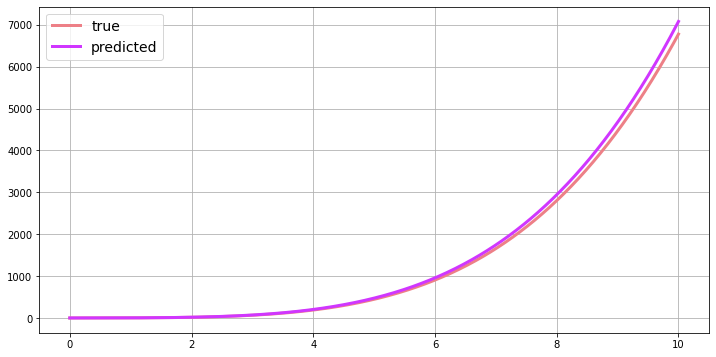

In [36]:
best_weight = new_pop[np.argmin(fitnessNumpy(weight, new_pop))]
y_pred = np.array([
    best_weight[0] * (x**4) + 
    best_weight[1] * (x**3) + 
    best_weight[2] * (x**2) + 
    best_weight[3] * x +
    best_weight[4] for x in x         
])

fig, ax = plt.subplots(figsize = (12, 6))
ax.plot(x, y, label='true', color='#ed8087', linewidth=3)
ax.plot(x, y_pred, label='predicted', color='#d036ff', linewidth=3)
ax.grid(True)
ax.legend(fontsize=14)
plt.savefig('cpu.jpg')
plt.show()

## table best weight and true weight

In [37]:
data = pd.DataFrame(data={
    'best_weight': best_weight,
    'true_weight': weight
})

In [38]:
data

,best_weight,true_weight
0,0.679996,0.665073
1,0.184101,0.033650
2,0.878296,0.853839
3,0.909280,0.943613
4,0.431228,0.350260


## time statics

In [39]:
df = pd.DataFrame(data={
    'CPU':{
        'time':time_cpu,
        'gen':max_gen
    }
})

In [40]:
def fitnessTorch(weight, pop):
    out = torch.zeros(pop.shape[0]).cuda()
    for i in range(pop.shape[0]):
        out[i] = torch.linalg.norm(weight - pop[i]).cuda()
    return out

In [41]:
def parentsTorch(pop, fitness, num_parents):
    parents = torch.empty((num_parents, pop.shape[1])).cuda()
    for parent_num in range(num_parents):
        max_fitness_idx = torch.argmin(fitness)
        parents[parent_num, :] = pop[max_fitness_idx, :]
        fitness[max_fitness_idx] = 9e9
    return parents

In [42]:
def crossoverTorch(parents, offspring_size):
    offspring = torch.empty(offspring_size).cuda()
    crossover_point = np.uint8(offspring_size[1]/2)

    for k in range(offspring_size[0]):
        parent1_idx = k % parents.shape[0]
        parent2_idx = (k + 1) % parents.shape[0]
        offspring[k, :crossover_point] = parents[parent1_idx, :crossover_point]
        offspring[k, crossover_point:] = parents[parent2_idx, crossover_point:]

    return offspring

In [43]:
def mutationTorch(offspring_crossover):
    for idx in range(offspring_crossover.shape[0]):
        random_value = torch.randn(1).cuda()
        offspring_crossover[idx, 2] = offspring_crossover[idx, 2] + random_value

    return offspring_crossover

In [44]:
t = time.time()
weight = torch.from_numpy(weight).cuda()
new_pop = torch.from_numpy(new_pop).cuda()
for _ in range(max_gen):
    fitness = fitnessTorch(weight, new_pop)
    parents = parentsTorch(new_pop, fitness, num_parents)
    offspring_crossover = crossoverTorch(parents, offspring_size=(pop_size[0] - parents.shape[0], num_weight))
    offspring_mutation = mutationTorch(offspring_crossover)
    new_pop[:parents.shape[0], :] = parents
    new_pop[parents.shape[0]:, :] = offspring_mutation
timeTorch = round(time.time() - t, 2)

In [45]:
timeTorch

0.89

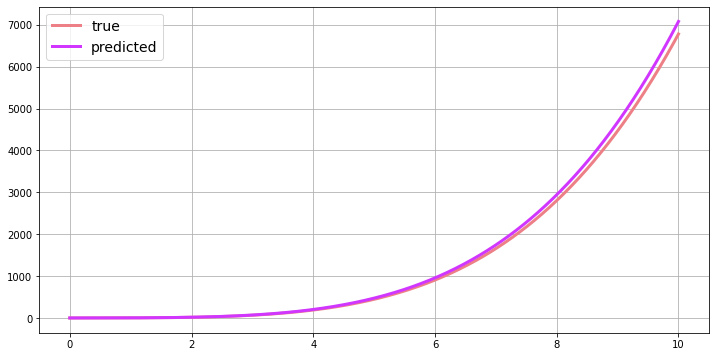

In [48]:
best_weight = new_pop[torch.argmin(fitnessTorch(weight, new_pop))]
y_pred = np.array([
    best_weight[0] * (x**4) + 
    best_weight[1] * (x**3) + 
    best_weight[2] * (x**2) + 
    best_weight[3] * x +
    best_weight[4] for x in x         
])

fig, ax = plt.subplots(figsize = (12, 6))
ax.plot(x, y, label='true', color='#ed8087', linewidth=3)
ax.plot(x, y_pred, label='predicted', color='#d036ff', linewidth=3)
ax.grid(True)
ax.legend(fontsize=14)
plt.savefig('gpu.jpg')
plt.show()

fig.show()

